# LDA with Sentences

In [1]:
# TODO: Fix the model
# TODO: Add a baseline model
# TODO: Save the model

In [2]:
import pandas as pd
import os
import csv
import nltk  # If this step fails, rerun 07-Install-NLTK.ipynb
import string

# Identify the working directory and data files
working_directory = "./32-LDA-with-Sentences"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [3]:
# Topics range
min_topics = 1
max_topics = 25

# Number of training passes for LDA
passes = 10

# The number of top words per topic
num_top_words = 10

# A row to use for verification of processing
verification_row = 9

In [4]:
%pip install --quiet --upgrade nltk gensim spacy pyldavis sentence-transformers hdbscan mpld3

Note: you may need to restart the kernel to use updated packages.


In [5]:
!python -m nltk.downloader --quiet 'all'
!python -m spacy download en_core_web_sm > /dev/null

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
# Read the preprocessed data into a dataframe
import pickle

with open("./21-Preprocess-Combined-Data-v2/dataframe.pickle", "rb") as f:
    df = pickle.load(f)

In [7]:
df.shape

(5736, 20)

In [8]:
df.head(1)

,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,UDI-DI,UDI-PUBLIC,DATE_OF_EVENT,REPORTER_OCCUPATION_CODE,REPORT_DATE,EVENT_LOCATION,SOURCE_TYPE,TOKENIZED_TEXT,NOPUNCT_TEXT,NOSTOPWORDS_TEXT,NODIGITS_TEXT,POS_TEXT,LEMMATIZED_TEXT,STEMMED_TEXT
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,,,07/30/2020,000,,I,CONSUMER,"[it, was, reported, that, the, transmitter, lo...","[it, was, reported, that, the, transmitter, lo...","[reported, transmitter, lost, connection, pump...","[reported, transmitter, lost, connection, pump...","[(reported, VBN), (transmitter, NN), (lost, VB...","[report, transmitter, lose, connection, pump, ...","[report, transmitt, lost, connect, pump, great..."


In [9]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        "SENTENCE_ID",
        "SENTENCE",
        "ROW_ID",
        "FOI_TEXT",
        "DEVICE_PROBLEM_CODE",
        "DEVICE_PROBLEM_TEXT",
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row["FOI_TEXT"]):
        sentence_data = {
            "SENTENCE": sentence,
            "SENTENCE_ID": sentence_counter,
            "ROW_ID": row["ROW_ID"],
            "FOI_TEXT": row["FOI_TEXT"],
            "DEVICE_PROBLEM_CODE": row["DEVICE_PROBLEM_CODE"],
            "DEVICE_PROBLEM_TEXT": row["DEVICE_PROBLEM_TEXT"],
        }
        sentences_df = sentences_df.append(sentence_data, ignore_index=True)
        sentence_counter = sentence_counter + 1

In [10]:
sentences_df.shape

(25686, 5)

In [11]:
sentences_df.head()

,SENTENCE,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT
0,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem
1,THE TRANSMITTER ULTIMATELY REGAINED CONNECTION...,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem
2,NO ADDITIONAL PATIENT OR EVENT INFORMATION WAS...,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem
3,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem
4,NO PRODUCT OR DATA WAS PROVIDED FOR EVALUATION.,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem


In [12]:
# Process the sentences
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words("english"))

punctuations = set(string.punctuation)


def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r"\b\d\w*\b", "", sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [
        token.translate(str.maketrans("", "", string.punctuation))
        for token in sentence_tokens
    ]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]

    # Lemmatize
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, pos="v") for token in sentence_tokens
    ]

    # Rebuild the sentence
    sentence = " ".join(lemmatized_tokens)

    return sentence


sentences_df["PROCESSED_SENTENCE"] = sentences_df["SENTENCE"].apply(process_sentence)

In [13]:
print(
    f"'{sentences_df['SENTENCE'][verification_row]}' ==> '{sentences_df['PROCESSED_SENTENCE'][verification_row]}'"
)

'THE PROBABLE CAUSE COULD NOT BE DETERMINED.' ==> 'probable cause could determine'


In [15]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import tqdm

step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# split each sentence into a list of words
texts = (
    sentences_df["PROCESSED_SENTENCE"].apply(lambda x: nltk.word_tokenize(x)).tolist()
)

# Create a dictionary from the words
dictionary = corpora.Dictionary(texts)

# Create a bag-of-words representation of the corpus
corpus = [dictionary.doc2bow(word) for word in texts]

# Initialize the scoreboard
coherence_scores_df = pd.DataFrame(columns=["k", "Coherence Score"])

pbar = tqdm.tqdm(total=len(topics_range))

for k in range(min_topics, max_topics + 1):
    # Train the LDA model
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=k, passes=passes
    )

    coherence_model = CoherenceModel(
        model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v"
    )

    coherence_score = coherence_model.get_coherence()

    coherence_scores_df = coherence_scores_df.append(
        pd.Series([k, coherence_score], index=coherence_scores_df.columns),
        ignore_index=True,
    )

    pbar.update(1)

pbar.close()
coherence_scores_df

 71%|███████   | 17/24 [08:15<03:33, 30.48s/it]/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
25it [12:23, 29.73s/it]                        


,k,Coherence Score
0,1.0,0.475017
1,2.0,0.380803
2,3.0,0.371169
3,4.0,0.367469
4,5.0,0.334116
5,6.0,0.371339
6,7.0,0.357839
7,8.0,0.361991
8,9.0,0.334472
9,10.0,0.340869


## Start of Analysis Section

In [16]:
# save the coherence_scores_df code to a file as HTML
with open(
    f"{working_directory}/lda_using_sentences_coherence_scores_table.html", "w"
) as f:
    f.write(coherence_scores_df.to_html(index=False))

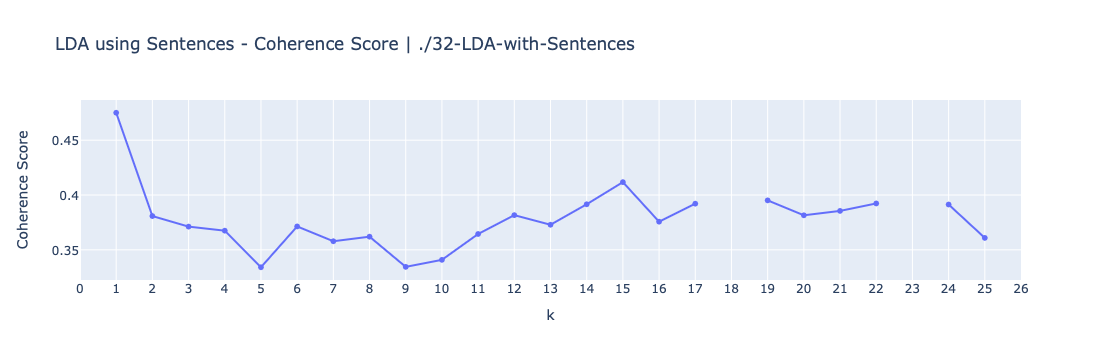

In [21]:
import plotly.express as px

fig_1 = px.line(
    coherence_scores_df,
    x="k",
    y="Coherence Score",
    title=f"LDA using Sentences - Coherence Score | {working_directory}\n",
)

# add markers for each point
fig_1.update_traces(mode="lines+markers")

# extend the limits of the x-axis from 0 to 16
fig_1.update_xaxes(range=[0, max_topics + 1])

# show all numbers on the x-axis
fig_1.update_layout(xaxis=dict(tickmode="linear"))

# write the graph to a file in the working directory
fig_1.write_html(f"{working_directory}/lda_using_sentences_coherence_scores_chart.html")

# show the plot
fig_1.show()

In [18]:
# Select the highest score

# Sort the dataframe by Coherence Score in descending order
sorted_df = coherence_scores_df.sort_values(by="Coherence Score", ascending=False)

# Pick the value of k from the first row of the sorted dataframe
selected_k = sorted_df.iloc[0]["k"]

print(f"Highest Coherence Score: {selected_k} = {sorted_df.iloc[0]['Coherence Score']}")

Highest Coherence Score: 1.0 = 0.47501698081688665


In [26]:
# Overriding selected_k
selected_k = 15

In [29]:
# Create an LDA model using the selected k
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=selected_k, passes=passes
)

In [ ]:
# Get the topics and add them to a dataframe
topics = lda_model.print_topics(num_topics=selected_k, num_words=num_top_words)
topics_df = pd.DataFrame(topics, columns=["Topic", f"Top {num_top_words} Words"])

In [38]:
with pd.option_context("display.max_colwidth", None):
    display(topics_df)

,Topic,Top 10 Words
0,0,"0.259*""device"" + 0.086*""however"" + 0.085*""operate"" + 0.052*""within"" + 0.051*""specification"" + 0.046*""session"" + 0.044*""sensor"" + 0.044*""multiple"" + 0.044*""support"" + 0.037*""attempt"""
1,1,"0.104*""bg"" + 0.103*""glucose"" + 0.099*""read"" + 0.085*""cgm"" + 0.073*""meter"" + 0.065*""report"" + 0.054*""blood"" + 0.050*""mgdl"" + 0.048*""monitor"" + 0.048*""continuous"""
2,2,"0.173*""error"" + 0.167*""report"" + 0.163*""transmitter"" + 0.145*""fail"" + 0.130*""occur"" + 0.024*""grid"" + 0.024*""park"" + 0.024*""fall"" + 0.023*""zone"" + 0.021*""value"""
3,3,"0.437*""product"" + 0.340*""evaluate"" + 0.043*""pending"" + 0.036*""state"" + 0.018*""alert"" + 0.017*""low"" + 0.012*""hospital"" + 0.012*""battery"" + 0.008*""give"" + 0.005*""measure"""
4,4,"0.158*""patient"" + 0.130*""event"" + 0.124*""additional"" + 0.124*""information"" + 0.122*""available"" + 0.064*""inspection"" + 0.064*""visual"" + 0.063*""perform"" + 0.063*""pass"" + 0.052*""external"""
5,5,"0.102*""connection"" + 0.095*""report"" + 0.094*""pump"" + 0.093*""b"" + 0.091*""sensor"" + 0.085*""transmitter"" + 0.082*""insert"" + 0.065*""lose"" + 0.057*""abdomen"" + 0.051*""greater"""
6,6,"0.176*""report"" + 0.176*""occur"" + 0.153*""loss"" + 0.149*""signal"" + 0.140*""hour"" + 0.139*""one"" + 0.015*""sensor"" + 0.007*""wire"" + 0.006*""alert"" + 0.005*""failure"""
7,7,"0.337*""allegation"" + 0.335*""confirm"" + 0.155*""data"" + 0.152*""evaluate"" + 0.004*""audio"" + 0.003*""output"" + 0.002*""reflect"" + 0.002*""full"" + 0.001*""correction"" + 0.001*""require"""
8,8,"0.163*""customer"" + 0.122*""send"" + 0.122*""replacement"" + 0.079*""transmitter"" + 0.065*""sensor"" + 0.055*""mobile"" + 0.051*""relate"" + 0.050*""determine"" + 0.048*""application"" + 0.034*""loss"""
9,9,"0.229*""evaluation"" + 0.188*""product"" + 0.153*""data"" + 0.151*""provide"" + 0.074*""return"" + 0.038*""receive"" + 0.027*""expiration"" + 0.022*""sensor"" + 0.021*""early"" + 0.021*""replace"""


In [39]:
# save the topics_df code to a file as HTML
with open(
    f"{working_directory}/lda_using_sentences_topics_and_words_table.html", "w"
) as f:
    f.write(topics_df.to_html(index=False))

In [36]:
# Write the sentences dataframe to a CSV file
sentences_df.to_csv(f"{working_directory}/sentences_dataframe.csv", index=False)

In [41]:
from project_utilities import upload_to_s3

upload_to_s3()

upload: ./index.html to s3://praxis-2023-html-output/index.html

fin
